In [1]:
import numpy as np
import matplotlib.pyplot as plt

from algorithms.lucb import ArgmaxUCB
from algorithms.ecolog import ECOLOG
from algorithms.max_uncertainty import MaxUncertainty
from algorithms.ucb_lcb import UCBLCB
from algorithms.uniform_with_argmax import UniformWithArgmax
from algorithms.uniform import Uniform

from envs.adv4_bandit import AdvBandit4
from envs.guassian_bandit import GuassianBandit

ModuleNotFoundError: No module named 'envs.guass_bandit'

In [2]:
def interact(
    env,
    ALG,
    n_steps=1000,
):
    alg = ALG(
        env.arms,
        param_norm_ub=env.public_info()["true_param_norm_up"],
    )
    context = env.context
    correct_arm = 0
    for i in range(n_steps):
        arm1, arm2 = alg.get_arms(context)
        if arm1 == context or arm2 == context:
            correct_arm += 1
        assert arm1 != arm2, "The algorithm should not choose the same arm twice"
        previous_context = context
        result, context = env.duel(arm1, arm2)
        alg.update(previous_context, arm1, arm2, result)
        if i % 100 == 0:
            print(f"Step {i}: {ALG.__name__}, correct arm: {correct_arm / (i + 1)}")
    return alg, correct_arm / n_steps

In [15]:
n_arms = 30
n_contexts = 30
runs = 5
d = 30
n_steps = 500
ALGS = [
    ArgmaxUCB,
    UCBLCB,
    ECOLOG,
    MaxUncertainty,
    Uniform,
    UniformWithArgmax,
]
BANDIT = AdvBandit4
# BANDIT = GuassianBandit
algs = {ALG.__name__: [] for ALG in ALGS}
correct_arms = {ALG.__name__: [] for ALG in ALGS}
envs = []
for run in range(runs):
    env = BANDIT(
        n_arms=n_arms,
        n_contexts=n_contexts,
        d=d,
        fit_into_unit_ball=True,
    )
    envs.append(env)
    for ALG in ALGS:
        print(f"Running {ALG.__name__} run {run}, correct arms: {correct_arms}")
        alg, ca = interact(env, ALG, n_steps=n_steps)
        algs[ALG.__name__].append(alg)
        correct_arms[ALG.__name__].append(ca)

Running ArgmaxUCB run 0, correct arms: {'ArgmaxUCB': [], 'UCBLCB': [], 'ECOLOG': [], 'MaxUncertainty': [], 'Uniform': [], 'UniformWithArgmax': []}
Step 0: ArgmaxUCB, correct arm: 0.0
Step 100: ArgmaxUCB, correct arm: 0.37623762376237624
Step 200: ArgmaxUCB, correct arm: 0.40298507462686567
Step 300: ArgmaxUCB, correct arm: 0.43853820598006643
Step 400: ArgmaxUCB, correct arm: 0.4463840399002494
Running UCBLCB run 0, correct arms: {'ArgmaxUCB': [0.446], 'UCBLCB': [], 'ECOLOG': [], 'MaxUncertainty': [], 'Uniform': [], 'UniformWithArgmax': []}
Step 0: UCBLCB, correct arm: 0.0
Step 100: UCBLCB, correct arm: 0.22772277227722773
Step 200: UCBLCB, correct arm: 0.27860696517412936
Step 300: UCBLCB, correct arm: 0.29900332225913623
Step 400: UCBLCB, correct arm: 0.30174563591022446
Running ECOLOG run 0, correct arms: {'ArgmaxUCB': [0.446], 'UCBLCB': [0.316], 'ECOLOG': [], 'MaxUncertainty': [], 'Uniform': [], 'UniformWithArgmax': []}
Step 0: ECOLOG, correct arm: 0.0
Step 100: ECOLOG, correct arm

In [16]:
def compute_simple_regret(algs, env, checkpoints):
    regrets = {alg_name: [] for alg_name in algs.keys()}
    for checkpoint in checkpoints:
        for alg_name, alg in algs.items():
            policy = alg.get_policy(checkpoint)
            regret = 0
            for context in range(env.n_contexts):
                best_arm = env.best_arm(context)
                chosen_arm = policy(context)
                regret += np.dot(
                    (env.arms[context, best_arm] - env.arms[context, chosen_arm]),
                    env.theta,
                )
                assert regret >= 0
            regrets[alg_name].append(regret / env.n_contexts)
    return regrets


def plot_simple_regrets(checkpoints, simple_regrets_across_runs):
    plt.figure(figsize=(16, 8))
    for alg_name, regret_list in simple_regrets_across_runs.items():
        rs = np.array(regret_list)  # shape: (n_runs, n_checkpoints)
        means = np.mean(rs, axis=0)
        stds = np.std(rs, axis=0)
        plt.plot(checkpoints, means, label=alg_name)
        plt.fill_between(checkpoints, means - stds, means + stds, alpha=0.2)
    plt.xlabel("Checkpoints")
    plt.ylabel("Simple Regrets")
    plt.title("Simple Regrets vs Checkpoints")
    plt.legend()
    plt.show()

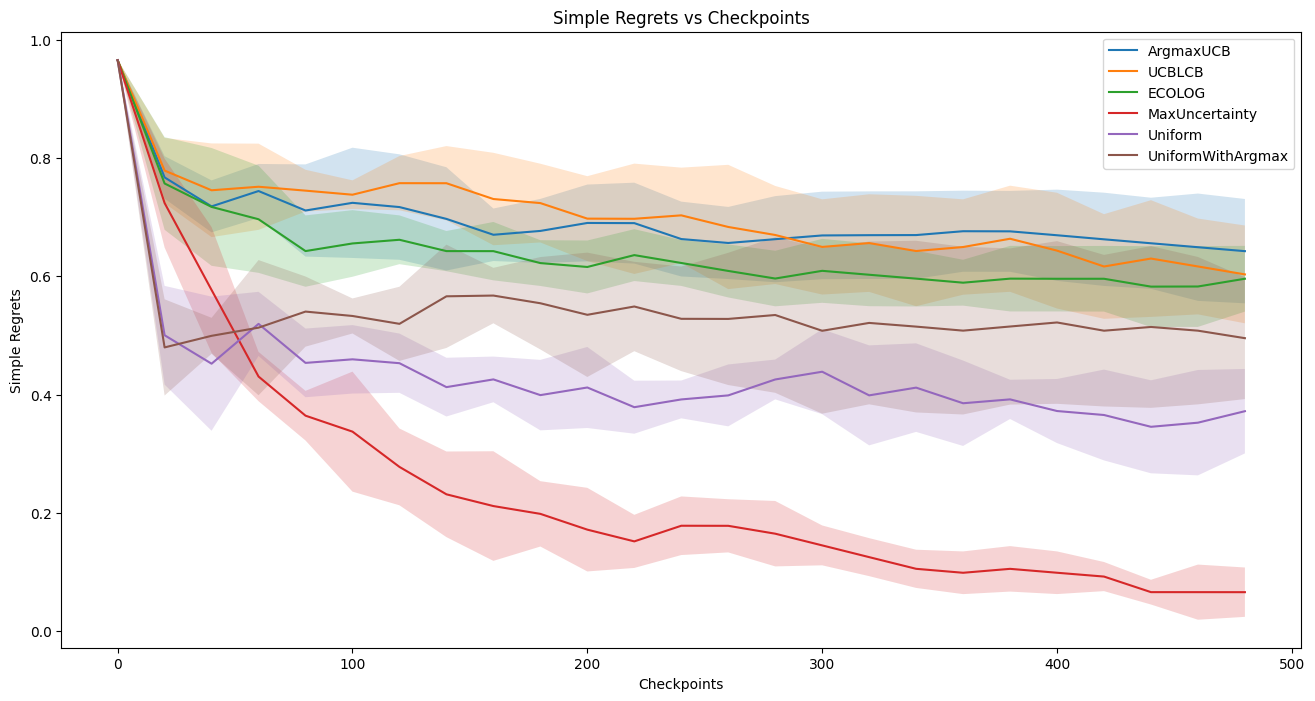

In [17]:
checkpoints = range(0, n_steps, 20)
simple_regrets_across_runs = {ALG.__name__: [] for ALG in ALGS}
for i in range(runs):
    algs_i = {ALG.__name__: algs[ALG.__name__][i] for ALG in ALGS}
    env = envs[i]
    env.adv = False
    simple_regrets = compute_simple_regret(algs_i, envs[i], checkpoints)
    for ALG in ALGS:
        simple_regrets_across_runs[ALG.__name__].append(simple_regrets[ALG.__name__])
    # So at the end, simple_regrets_across_runs is a dictionary of lists of lists
    # where the outer list is indexed by algorithm name, the middle list is indexed
    # by runs, and the inner list is indexed by checkpoints.

plot_simple_regrets(checkpoints, simple_regrets_across_runs)

In [6]:
n_arms = 100
n_contexts = 100
runs = 5
d = 30
n_steps = 500
env = AdvBandit4(
    n_arms=n_arms,
    n_contexts=n_contexts,
    d=d,
)

In [29]:
for c in range(n_contexts):
    for i in range(n_arms):
        if i == c % n_arms:
            print(f"Context {env.arms[c, c % n_arms]}")
            continue

        assert env.arms[c, i].sum() == 0

Context [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Context [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Context [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Context [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Context [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Context [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Context [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Context [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Context [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Context [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 